# Introduction to MiniPipe

The easiest way to understand MiniPipe is to dive into some examples. So let's first look at a simple toy example of a mini-batch pipeline. This example is just to demonstrate the basic functionality of MiniPipe. We'll get to some real-world applications later on. 

## Serial Pipelines

Most machine learning pipeline will have at least three stages: load, transform and train. In this example we'll simulate these three stages with these simple functions

In [1]:
import time

# 'loads' data
def loader(n):
    for i in range(n):
        time.sleep(0.5)
        yield i

# performs square transformation to data        
def trans(x):
    time.sleep(1)
    return x**2

# prints data
def output(x):
    time.sleep(0.5)
    print('x = {}'.format(x))

The first function, `loader`, returns a python generator, which we'll use to generate our "data". I've added a delay of 0.5s into the generator to simulate loading time. The next function `transform` is a simple transformation on our data (squares the input), which takes twice as long (1s) as loading. Finally `output` simply prints our data to stdout, also taking 0.5s.

Of course in this simple example we can fit all the “data” into memory, but lets pretend like that's not the case. We need to load one chunk of data at a time, where each data chunk is returned with the `next(loader())` method. 

Lets setup a serial pipeline without MiniPipe, where we get the data, transform it and then save it one batch at a time. We'll use jupyter's %%timeit magic cell to time execution time. 

In [43]:
%%timeit -n 1 -r 1

# initialize loader
ldr = loader(10)

# run pipeline
for data in ldr: 
    x = trans(data)
    output(x)

x = 0
x = 1
x = 4
x = 9
x = 16
x = 25
x = 36
x = 49
x = 64
x = 81
20 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The for loop calls the `next(lrd)` method 10 times sequentially, each time applying `transform` followed by `output`. As expected the execution time takes about 20s since each iteration takes a total of 2s (0.5s + 1s + 0.5s) and it's repeated 10 times.

## Pipeline Parallelism

Now lets see what the same pipeline looks like in MiniPipe.

In [34]:
from minipipe import Source, Transform, Sink

@Source
def loader(n):
    for i in range(n):
        time.sleep(0.5)
        yield i
        
@Transform
def trans(x):
    time.sleep(1)
    return x**2

@Sink
def output(x):
    time.sleep(0.5)
    print('x = {}'.format(x))

MiniPipe has three basic types of pipe segments: Sources, Transforms and Sinks. Above we've used a Python decorator to wrap our function definitions with a pipe class. Alternatively,  we could have used syntax `trans = Transform(trans)` to achieve the same thing. The wrapped function `trans` still acts the same as before, it's just been decorated with other attributes that allow it to be run in a pipeline. 

For example,  

In [49]:
x = 2
print(f'{trans.__name__}({x}) = {trans(x)}')

trans(2) = 4


still works as expected.

We build pipelines by adding pipe segments to the `Pipeline` object and calling the `Pipeline.build` method. 

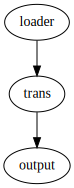

In [35]:
from minipipe import Pipeline

# initialize loader
ldr = loader(10)

# build pipeline
pline = Pipeline()
pline.add(ldr)
pline.add(trans)
pline.add(output) 
pline.build()

# draw pipeline
pline.diagram()

To run the pipeline we simply need to call the `Pipeline.run` method. 

In [47]:
pline.run(timeit=True)

x = 0
x = 1
x = 4
x = 9
x = 16
x = 25
x = 36


2020-03-01 16:38:18,409 - INFO - loader - End of stream


x = 49


2020-03-01 16:38:19,411 - INFO - loader - Local termination


x = 64


2020-03-01 16:38:20,413 - INFO - trans - Local termination


x = 81


2020-03-01 16:38:20,915 - INFO - save - Local termination
2020-03-01 16:38:20,920 - INFO - main - Warm-up time: 0.01s
2020-03-01 16:38:20,922 - INFO - main - Run time: 11.02s
2020-03-01 16:38:20,923 - INFO - main - Total time: 11.04s


We see from the logging (which can be set in `PipeLine.__init__` with `log_lvl`) where each pipe segment shutdown. Source shutdown first---after the end of the stream---followed by Transform and Sink. 

The execution time is now 11s instead of 20s. That's because each pipe segments executes on it's own process allowing for parallel execution. Of course dependent nodes still have to wait for data to be passed downstream, but once data is passed the node can start on the next batch without waiting for the full pipeline to be executed. Thus we expect the total time to be 0.5s (initial load) + 10 x (1s) + 0.5s (final save) = 11s. 

MiniPipe will place each pipe segment on its own process. Each process runs independently in an asynchronous fashion. MiniPipe is an API built on top of Python's Multiprocessing library and optionally Pyarrow.plasma. 

There is no limit to the number of processes you can run, however you are limited by the number of physical cores on your machine. For computation heavy pipelines bound to the CPU you may see performance degradation if the number of pipe segments exceed the number of physical cores. On the other hand, for I/O processes such as loading or computation that's bound to the GPU, such as training, this should be less of an issue. 

## Horizontal Scaling

Since `trans` takes twice as long as `loader` and `save` we can additionally speed things up by increasing the number of Transform processes. Minipipe is designed for this type of horizontal parallelization as well.

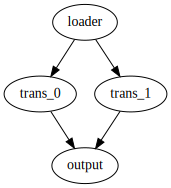

In [51]:
# initialize loader
ldr = loader(10)

# build pipeline
pline = (Pipeline()
         .add(ldr)                 # .add returns self
         .add([trans, trans])      # so you can chain pipes 
         .add(output)              # like so 
         .build())                 # and build chains too 

# draw pipeline
pline.diagram()                    # this does not chain

We setup the pipeline exactly as before, except now when we add Transform to the pipeline we create two nodes. However it's somewhat unclear what happens to the data after Source. To understand what's happening here we have to introduce the concept of a Stream.

A Stream is a logical queue, in this case a `multiprocessing.Queue` object that holds the data while the pipe processes are busy. Each pipe segment is separated by a Stream forming a bipartite graph.

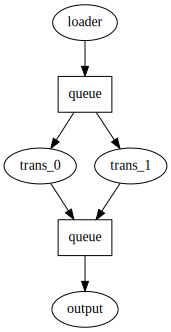

In [52]:
pline.diagram(draw_streams=True)

We see that `loader` puts data on its downstream queue while both `trans_0` and `trans_1` get data from that same queue. This allows the two Transform processes to executing asynchronously. The first available Transform process will take the data, so in this graph the order of data chunks in not necessarily preserved. 

In [11]:
pline.run(timeit=True)

x = 0
x = 1
x = 4
x = 9
x = 16
x = 25


2020-03-01 15:47:31,102 - INFO - loader - End of stream


x = 36


2020-03-01 15:47:31,602 - INFO - loader - Local termination


x = 49


2020-03-01 15:47:31,640 - INFO - trans_0 - Local termination


x = 64


2020-03-01 15:47:32,143 - INFO - trans_1 - Local termination


x = 81


2020-03-01 15:47:32,645 - INFO - save - Local termination
2020-03-01 15:47:32,650 - INFO - main - Warm-up time: 0.01s
2020-03-01 15:47:32,651 - INFO - main - Run time: 6.55s
2020-03-01 15:47:32,652 - INFO - main - Total time: 6.56s


We see it takes just over 6.5s as expected, about 1/3rd of the original execution time. 

At this point the only way to speed things up further is to introduce parallel load processes. This can be done by using two separate Sources each with their own generator function.

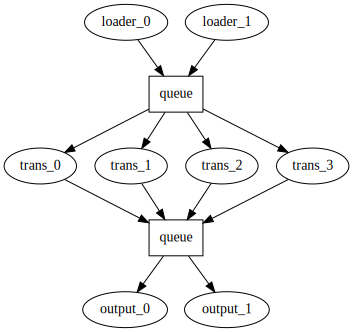

In [53]:
from copy import copy

@Source
def loader(start, stop, step):
    for i in range(start, stop, step):
        time.sleep(0.5)
        yield i

# initialize loaders
# loaders iterate over different values 
ldr1 = loader(0, 10, 2) 
ldr2 = loader(1, 10, 2)  

# build pipeline
pline = (Pipeline()
         .add([ldr1, ldr2])                       # two different Sources
         .add([trans]*4)                          # you may use list multiplication  
         .add([copy(output) for _ in range(2)])   # or make explicit copies              
         .build())                 

# draw pipeline
pline.diagram(True)                    

In [15]:
pline.run(timeit=True)

x = 0
x = 1


2020-03-01 15:53:28,920 - INFO - loader_0 - End of stream


x = 4
x = 9
x = 16
x = 25


2020-03-01 15:53:29,431 - INFO - trans_1 - Local termination
2020-03-01 15:53:29,435 - INFO - loader_0 - Local termination
2020-03-01 15:53:29,434 - INFO - loader_1 - End of stream


x = 36
x = 49


2020-03-01 15:53:29,937 - INFO - trans_3 - Local termination
2020-03-01 15:53:29,940 - INFO - save_0 - Local termination
2020-03-01 15:53:29,941 - INFO - loader_1 - Local termination


x = 64


2020-03-01 15:53:30,443 - INFO - trans_0 - Local termination


x = 81


2020-03-01 15:53:30,951 - INFO - save_1 - Local termination
2020-03-01 15:53:30,949 - INFO - trans_2 - Local termination
2020-03-01 15:53:30,958 - INFO - main - Warm-up time: 0.03s
2020-03-01 15:53:30,960 - INFO - main - Run time: 4.52s
2020-03-01 15:53:30,961 - INFO - main - Total time: 4.55s


## Stateful Pipe Segments

MiniPine also allows you to wrap Python classes for stateful pipe segments. For example create a Transform that keeps a running sum of values passed. 

In [31]:
@Transform
class cumsum:
    
    def __init__(self):
        self.n = 0
    
    @Transform.call
    def add_to_sum(self, x):
        self.n += x
        return self.n

The decorator `Transform.call` is used to tell MiniPipe which method to call on its upstream(s). This decorator is inherited from `Transform`'s parent class `Pipe` and may also be used with `Sink`. 

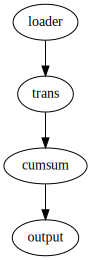

In [54]:
# initialize class pipe segments first
csum = cumsum()

pline = (Pipeline()
         .add(ldr)
         .add(trans)
         .add(csum)
         .add(output) 
         .build())

pline.diagram()

In [33]:
pline.run()

x = 0
x = 1
x = 5
x = 14
x = 30
x = 55
x = 91


2020-03-01 16:10:38,015 - INFO - loader - End of stream


x = 140


2020-03-01 16:10:39,016 - INFO - loader - Local termination


x = 204


2020-03-01 16:10:40,018 - INFO - trans - Local termination
2020-03-01 16:10:40,020 - INFO - cumsum - Local termination


x = 285


2020-03-01 16:10:40,521 - INFO - save - Local termination


Here we've initialized `self.n` on the main process, however you can initialize objects on the child process with the `Pipe.init` decorator. We can also use `Pipe.term` to call a method at the end of the stream, this is especially handy for saving data.  

In [5]:
@Transform
class cumsum:
    
    def __init__(self):
        self.n = 0
    
    @Transform.init       # runs on child process before stream
    def local_init(self):
        self.n = 10
    
    @Transform.call
    def add_to_sum(self, x):
        self.n += x
        return self.n
    
    @Transform.term      # runs on child process after stream
    def done(self):
        print('Saving data..')
        # save to disk
    
csum = cumsum()

pline = (Pipeline()
         .add(ldr)
         .add(trans)
         .add(csum)
         .add(output) 
         .build())

pline.run()

x = 10
x = 11
x = 15
x = 24
x = 40
x = 65
x = 101


2020-03-01 17:24:11,555 - INFO - loader - End of stream


x = 150


2020-03-01 17:24:12,557 - INFO - loader - Local termination


x = 214


2020-03-01 17:24:13,559 - INFO - trans - Local termination
2020-03-01 17:24:13,562 - INFO - cumsum - Local termination


Saving data..
x = 295


2020-03-01 17:24:14,062 - INFO - output - Local termination


However, we may want our pipeline to produce a result in memory rather that saving to disk. For this we can use the `Pipe.result` decorator. Like `Pipe.term` this method will only be called once at the end of the stream.  

In [6]:
@Transform
class cumsum:
    
    def __init__(self):
        self.n = 0
    
    @Transform.init     # runs on child process before stream
    def local_init(self):
        self.n = 10 
    
    @Transform.call
    def add_to_sum(self, x):
        self.n += x
        return self.n
    
    @Transform.result  # runs on child process after stream
    def done(self):
        return self.n  # value is stored and returned by Pipeline.run
    
csum = cumsum()

pline = (Pipeline()
         .add(ldr)
         .add(trans)
         .add(csum)
         .add(output) 
         .build())

res = pline.run()

x = 10
x = 11
x = 15
x = 24
x = 40
x = 65
x = 101


2020-03-01 17:24:22,609 - INFO - loader - End of stream


x = 150


2020-03-01 17:24:23,610 - INFO - loader - Local termination


x = 214


2020-03-01 17:24:24,612 - INFO - trans - Local termination
2020-03-01 17:24:24,614 - INFO - cumsum - Local termination


x = 295


2020-03-01 17:24:25,115 - INFO - output - Local termination


In [7]:
print(res)

{'cumsum': 295}


The all values returned by methods decorated by 'Pipe.result' will be stored a dictionary and returned by `Pipeline.run`. The keys correspond to the name of the pipe segment. Thus each stateful pipe segment may return it's own result. 

## Regulator Pipe Segments

A Regulator is a special type of pipe segment that has the ability to change the data-chunk throughput. Regulators are implemented with Python coroutines, which are restarted as soon as they're exhausted, i.e. when `next` raises `StopIteration`.  

In [54]:
from minipipe import Regulator
import numpy as np

@Regulator
def batch(batch_size):
    x_batch = []                    
    while len(x_batch) < batch_size:
        x_batch.append((yield))     # input from upstream
    yield x_batch                   # outputs to downsteam

Here `x_batch` is initialized each time the coroutine is exhausted, thus there's no need to reinitialize it after yield. 

In [55]:
btchr = batch(2)

pline = (Pipeline()
         .add(ldr)
         .add(btchr)
         .add(output) 
         .build())

pline.run()

x = [0, 1]
x = [2, 3]
x = [4, 5]
x = [6, 7]


2020-03-01 18:42:26,883 - INFO - loader - End of stream
2020-03-01 18:42:26,887 - INFO - loader - Local termination
2020-03-01 18:42:26,889 - INFO - batch - Local termination


x = [8, 9]


2020-03-01 18:42:27,387 - INFO - output - Local termination


## Pipe Segments with Multiple Up/Down Streams

It's possible for pipe segments to have multiple upstream and/or downstream. However, one must then explicitly pass the upstreams and downstreams to the `Pipeline.add` method. But first we must modify the `loader` to return multiple objects. 

In [31]:
@Source
def multiloader(n, n_outputs):
    for i in range(n):
        time.sleep(0.5)
        yield (i,)*n_outputs # returns a tuple of len n_outputs 

Likewise, if the pipe segment has multiple upstreams then the pipe needs to have multiple input args. 

In [42]:
@Transform
def agg(*args):  # captures all inputs in list
    return sum(args)

The number of inputs/outputs to the pipe segment should equal the number of upstrearms/downstreams.  

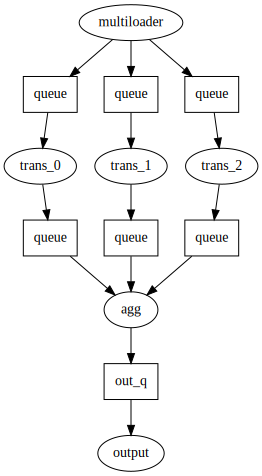

In [53]:
from minipipe import Stream

n_trans = 3
mldr = multiloader(10, n_trans)

# initialize standard multiprocess.Queue streams
trans_upstreams = [Stream() for _ in range(n_trans)]
trans_downstreams = [Stream() for _ in range(n_trans)]
output_stream = Stream() 

pline = Pipeline()
pline.add(mldr, downstream=trans_upstreams)

for i in range(n_trans):
    pline.add(trans, upstream=trans_upstreams[i], 
                     downstream=trans_downstreams[i])
    
pline.add(agg, upstream=trans_downstreams, 
               downstream=output_stream)

pline.add(output, upstream=output_stream) 
pline.build()

pline.diagram(True)

In [47]:
pline.run()

x = 0
x = 3
x = 12
x = 27
x = 48
x = 75
x = 108


2020-03-01 18:31:31,493 - INFO - multiloader - End of stream


x = 147
x = 192


2020-03-01 18:31:33,496 - INFO - multiloader - Local termination
2020-03-01 18:31:33,494 - INFO - trans_0 - Local termination
2020-03-01 18:31:33,496 - INFO - trans_1 - Local termination
2020-03-01 18:31:33,496 - INFO - trans_2 - Local termination
2020-03-01 18:31:33,499 - INFO - agg - Local termination


x = 243


2020-03-01 18:31:33,999 - INFO - output - Local termination


## Switch Pipe Segments

When a pipe segment is passed a Python `None` from upstream it's ignored. This means the pipe will not perform any processing on it. This allows the user to construct switches, which may pass data to one or another downstream. 

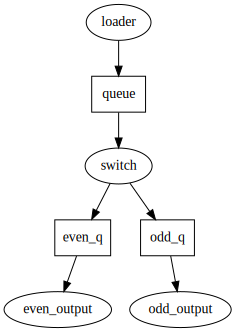

In [50]:
@Transform 
def switch(x):
    if x % 2 == 0:
        return (x, None)
    else:
        return (None, x)

@Sink
def even_output(x):
    print(f'{x} is even')
    
@Sink
def odd_output(x):
    print(f'{x} is odd')
    
ldr = loader(10)
output_streams = [Stream(name='even_q'), # Streams may be named
                  Stream(name='odd_q')]

pline = (Pipeline()
         .add(ldr)
         .add(switch, downstream=output_streams)
         .add(even_output, upstream=output_streams[0])
         .add(odd_output,  upstream=output_streams[1]) 
         .build())

pline.diagram(True)

In [51]:
pline.run()

0 is even
1 is odd
2 is even
3 is odd
4 is even
5 is odd
6 is even
7 is odd
8 is even
9 is odd


2020-03-01 18:37:55,016 - INFO - loader - End of stream
2020-03-01 18:37:55,021 - INFO - loader - Local termination
2020-03-01 18:37:55,023 - INFO - even_output - Local termination
2020-03-01 18:37:55,023 - INFO - odd_output - Local termination
2020-03-01 18:37:55,023 - INFO - switch - Local termination
